# Predecir si el ejercicio es correcto
Aplicar Machine Learning para predecir si el paciente está realizando correctamente el ejercicio (clasificación binaria)

In [9]:
# ---------- importar librerías---------
# Manipular los datos
import pandas as pd

# Gráficas
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8')
sns.set_theme(style="darkgrid")

# scikit-learn (ML en python)
## Procesar el dataset
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
## Modelos ML
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
## Evaluación de los modelos
from sklearn.metrics import *
from sklearn.model_selection import cross_val_score
## Hiperparametrizacion
from sklearn.model_selection import GridSearchCV
## Seleccion de variables
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import RFECV # recursive

# Class imbalance
from imblearn.under_sampling import NearMiss, EditedNearestNeighbours
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.combine import SMOTETomek, SMOTEENN
from collections import Counter

## Seleccion de variables
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import RFECV # recursive
from sklearn.decomposition import PCA

# Pipeline
from imblearn.pipeline import Pipeline


# Para ignorar los Warnings
import warnings
from sklearn.exceptions import FitFailedWarning 

warnings.simplefilter(action = 'ignore', category = FutureWarning)
warnings.simplefilter(action = 'ignore', category = UserWarning)

In [10]:
#---------Importar los datos-----------
# Dataframe medidas calculadas por repetición
df = pd.read_csv('../csvFiles/medidasPerRepetition.csv', dtype=object)

In [11]:
# ------Preparar el dataset-------
encoder = OrdinalEncoder(categories=[list(set(df["Position"].values))])
encoder.fit(df[["Position"]])
df["Position"] = encoder.transform(df[["Position"]])

# pasar variable obj to numeric
df = df.apply(pd.to_numeric, errors='ignore')

# cmabiar las poorly executed to incorrectly executed
df[df['CorrectLabel']==3] = 2

In [5]:
df

,SubjectID,GestureLabel,RepetitionNumber,CorrectLabel,Position,Duration,HipAngleRight_standardDeviation,ShoulderAngleRight_standardDeviation,RightArmAngle_standardDeviation,KneeAngleRight_standardDeviation,...,ElbowAngleRight_Kurtosis,KneeAngleLeft_Kurtosis,AnkleAngleRight_Kurtosis,ShoulderAngleLeft_Kurtosis,WristAngleLeft_Kurtosis,HipAngleLeft_Kurtosis,ArmsTogetherAngle_Kurtosis,WristAngleRight_Kurtosis,AnkleAngleLeft_Kurtosis,LeftArmAngle_Kurtosis
0,101,0,1,1,3.0,59,0.144295,2.639654,2.765557,0.395857,...,-1.509605,1.771001,-0.404407,-0.635142,-1.154852,0.062256,-0.604303,0.198533,-0.042840,0.537440
1,101,0,2,1,3.0,44,0.062351,2.835377,2.298280,0.169096,...,-1.280617,-0.363962,-0.276498,-0.903003,-0.770170,-1.078167,0.893421,1.048145,-0.153995,0.726806
2,101,0,3,1,3.0,53,0.316554,2.282541,3.445304,0.178107,...,-1.455247,0.195184,-0.530532,0.412761,-0.580654,-0.941266,-0.413869,-0.393123,-0.579129,0.140506
3,101,0,4,1,3.0,57,0.302127,2.210172,3.626022,0.179247,...,-1.514596,-0.688205,-0.057357,-1.330692,-0.136403,-1.440586,-1.258808,-0.610934,0.855168,1.060234
4,101,0,5,1,3.0,60,0.408527,2.324567,3.767307,0.192051,...,-1.360146,1.957381,-0.322273,-0.844501,-0.426884,-1.091646,-0.338747,-1.170145,1.165992,-1.527706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2584,307,8,8,1,3.0,48,4.173285,0.311175,1.555034,1.206067,...,0.234936,-0.347162,-0.270964,-0.971195,-0.949755,-1.222994,-0.339300,0.056064,0.312861,-0.781945
2585,307,8,9,1,3.0,48,3.232178,0.314987,1.332626,1.591213,...,-0.759991,-0.874793,-1.671159,-0.963412,0.520658,-1.672822,-0.863515,-1.006323,1.056307,-1.644095
2586,307,8,10,1,3.0,47,3.299083,0.299210,1.315829,1.502639,...,-0.707586,-1.055977,-2.061997,0.037584,-0.834273,-1.403915,-0.449516,-0.776532,-0.851119,-0.826005
2587,307,8,11,1,3.0,51,3.980135,0.189624,1.896625,1.153539,...,-0.899253,-1.100134,-1.011064,-0.660478,-0.261026,-1.462976,-0.445218,-0.052683,-0.156794,-0.620023


ES EL NUMERO DE FRAMES NO DE PACIENTES

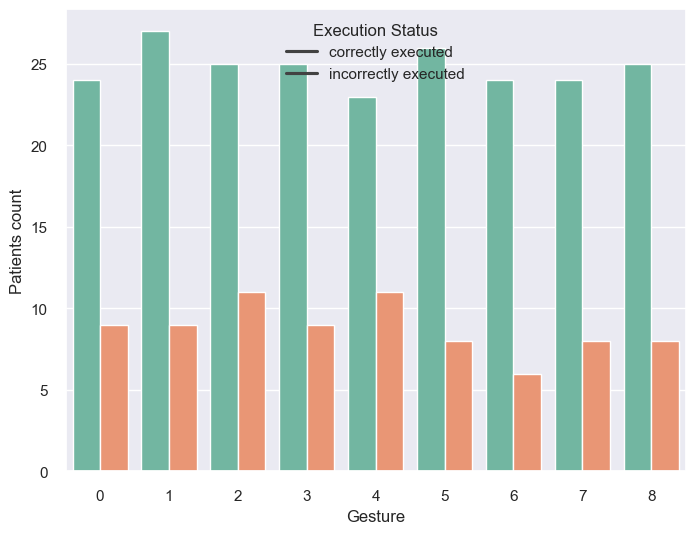

In [18]:
#---------Distribución de las clases--------

subject_count_per_gesture = df.groupby(["GestureLabel", "CorrectLabel"])["SubjectID"].nunique().reset_index()

# Plotting
plt.figure(figsize=(8, 6))
ax = sns.barplot(x="GestureLabel", y="SubjectID", hue="CorrectLabel", data=subject_count_per_gesture,
                 palette='Set2')

gesture_labels = ['EFL', 'EFR', 'SFL', 'SFR', 'SAL', 'SAR', 'SFE', 'STL', 'STR']
ax.set(xlabel='gesture_labels')

plt.legend(title='Execution Status', labels=["correctly executed", "incorrectly executed"])
plt.xlabel('Gesture')
plt.ylabel('Patients count')
plt.show()

## ML simple

In [5]:
#-------Funciones--------

# Para entrenar los modelos de ML
def aplicar_modelos(X: pd.DataFrame, y: pd.DataFrame, file):
    """
    Aplica una lista de modelos de aprendizaje automático a los datos de prueba y muestra
    los informes de evaluación.

    Parámetros:
    * X: datos de entrenamiento.
    * y: target de entrenamiento.
    * file: archivo para escribir los resultados.
    """
    # creación de los modelos
    knn = KNeighborsClassifier(n_neighbors=1)  # K-Neighbors classifier
    dtree = DecisionTreeClassifier()  # Decision tree
    nb = GaussianNB()  # Naive Bayes
    svm = SVC()  # Support Vector Machine
    rf = RandomForestClassifier(n_estimators=5)  # Random Forest
    lr = LogisticRegression(max_iter=500)  # Logistic Regression

    models = [knn, dtree, nb, svm, rf, lr]

    # Iteramos sobre los modelos
    for modelo in models:
        try:
            accuracy_scores = cross_val_score(modelo, X, y, cv=5, scoring='accuracy')
            recall_scores = cross_val_score(modelo, X, y, cv=5, scoring='recall')
            file.write(f"\n\t Modelo: {modelo.__class__.__name__}\n")
            file.write("\t%0.2f accuracy with a standard deviation of %0.2f\n" % (accuracy_scores.mean(), accuracy_scores.std()))
            file.write("\t%0.2f recall with a standard deviation of %0.2f\n" % (recall_scores.mean(), recall_scores.std()))            
        except ValueError as e:
            file.write(f"Skipping {modelo.__class__.__name__} due to ERROR: {e}\n")

# Aplicar imbalance learn
def aplicar_imblearn(X, y, file):
    nm1 = NearMiss(version=1, n_neighbors=2)
    enn = EditedNearestNeighbours()
    adasyn = ADASYN(n_neighbors=2)
    smote = SMOTE(k_neighbors=2)
    smotetomek = SMOTETomek(smote=smote)
    smote_enn = SMOTEENN(smote=smote)

    imblearns = [nm1, enn, adasyn, smote, smotetomek, smote_enn]
    for imblearn in imblearns:
        try:
            X_im, y_im = imblearn.fit_resample(X, y)
            file.write(f"\n- MODELO DE RESAMPLING: {imblearn.__class__.__name__}\n")
            file.write("Distribution of class labels before resampling {}\n".format(Counter(y)))
            file.write("Distribution of class labels after resampling {}\n".format(Counter(y_im)))
            aplicar_modelos(X_im, y_im, file)
        except ValueError as e:
            file.write(f"Skipping {imblearn.__class__.__name__} due to ERROR: {e}\n")
        except RuntimeError as e:
            file.write(f"Skipping {imblearn.__class__.__name__} due to ERROR: {e}\n")

# dividir en test y train df_gestures
def split_df_gestures(df):
    #---------Dividimos el dataset------------
    # dividimos en variables independientes y en target
    X = df.drop(['CorrectLabel'], axis=1)
    y = df['CorrectLabel']

    #---------Dividimos en train y test------------
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)    

    return X_train, X_test, y_train, y_test

In [6]:
gestures = [0, 1, 2, 4, 5, 6, 7, 8] #df['GestureLabel'].unique()

with open('cvResults.txt', 'w') as file:
    for gesture in gestures:
        df_gesture = df[df['GestureLabel'] == gesture]
        #---------Dividimos en train y test------------
        X_train, X_test, y_train, y_test = split_df_gestures(df_gesture)  

        file.write(f'\n------------ CLASIFICACION GESTO {gesture} -----------\n')
        aplicar_imblearn(X_train, y_train, file)

## Pipeline con hiperparametrizacion y feature selection

In [7]:
# Para ignorar los FitFileWarning
warnings.filterwarnings("ignore", category=FitFailedWarning)

# definimos el param_grid
param_grid = [
    {
        'balance_data__smote__k_neighbors': [2, 3, 4],
        'reduce_dim__n_components': [0.8, 0.90, 1],
        'classifier': [KNeighborsClassifier(n_neighbors=2)],
        'classifier__n_neighbors': [2, 3, 5], 
        'classifier__weights': ['uniform', 'distance'], 
        'classifier__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']  
    },
    {
        'reduce_dim__n_components': [0.7,0.8, 0.90, 1],
        'classifier': [DecisionTreeClassifier()],
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__max_depth': [None, 10, 20, 30]
    },
    {
        'reduce_dim__n_components': [0.7, 0.8, 0.90, 1],
        'classifier': [GaussianNB()]
    },
    {
        'reduce_dim__n_components': [0.7, 0.8, 0.90, 1],
        'classifier': [SVC()],
        'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'classifier__C': [0.1, 1, 10, 100]
    },
    {

        'reduce_dim__n_components': [0.7, 0.8, 0.90, 1],
        'classifier': [RandomForestClassifier()],
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_features': ['auto', 'sqrt', 'log2']
    },
    {

        'reduce_dim__n_components': [0.7, 0.8, 0.90, 1],
        'classifier': [LogisticRegression(max_iter=500)],
        'classifier__C': [0.01, 0.1, 1, 10, 100]
    }
]

with open('resultsPipeline.txt', 'w') as file:
    for gesture in df['GestureLabel'].unique():

        df_gesture = df[df['GestureLabel'] == gesture]

        #---------Dividimos en train y test------------
        X_train, X_test, y_train, y_test = split_df_gestures(df_gesture)   
        
        file.write(f'\n------------ CLASIFICACION GESTO {gesture} -----------\n')
        print(f'\n------------ CLASIFICACION GESTO {gesture} -----------\n')
        pipeline = Pipeline([('balance_data',  SMOTETomek(smote=SMOTE(k_neighbors=2))),
                            ('reduce_dim', PCA()),
                            ('classifier', KNeighborsClassifier(n_neighbors=2))])

        # Create the GridSearchCV object
        grid = GridSearchCV(pipeline, param_grid)
        grid.fit(X_train, y_train)
        best_pipeline = grid.best_estimator_

        file.write('Training set score: ' + str(best_pipeline.score(X_train, y_train)))
        file.write('Test set score: ' + str(best_pipeline.score(X_test, y_test)))

        print('Training set score: ' + str(best_pipeline.score(X_train, y_train)))
        print('Test set score: ' + str(best_pipeline.score(X_test, y_test)))

        globals()[f'best_pipe_{gesture}'] = best_pipeline




------------ CLASIFICACION GESTO 0 -----------

